In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from gensim.utils import simple_preprocess, tokenize
from gensim.summarization.textcleaner import split_sentences
from gensim.parsing import preprocessing
from gensim.models import Doc2Vec
from gensim.corpora import Dictionary


from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn import metrics # silhouette
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from multiprocessing import cpu_count

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm

# pd.set_option('display.max_colwidth',1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

%matplotlib inline

cuda


In [2]:
df = pd.read_json('data/dev/cluster_12_cats_index.json')

In [8]:
# df.drop(['title', 'body', 'subjects', 'date'], axis=1, inplace=True)

In [4]:
# df.to_json('data/dev/cluster_12_cats_index.json')

In [3]:
doc_vecs = pickle.load(open("data/dev/doc_vecs.pkl", "rb"))

In [4]:
def get_clusters(labels, df, ids):
    df2 = df.reset_index()
    df2 = df2.set_index('id')

    indexes = df2.loc[ids, 'index'].tolist()
    
    clusters = labels[indexes]
    
    return clusters
    

def visualize_trending(df):
#     target = df[df['target'] == True]
#     noise = df[df['target'] == False]
#     t_group = target.groupby(['time'])['id'].count()
#     n_group = noise.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()
    
def get_target(df):
    target = df[df['event'] != 'noise']['category'].iloc[0]
    return target

def get_cluster_change(clusters, sample, target, timeline=100):
    sample['cluster'] = clusters
    n_cluster = sample['cluster'].nunique()
    changes = []
    
    for g, cluster in sample.groupby('cluster'):
        # count and sort by timeline
        counts = cluster['time'].value_counts().sort_index()
        if len(counts) < timeline:
            miss_times = list(set(range(timeline)).difference(counts.index))
            fill_values = pd.Series(np.zeros(len(miss_times)), index=miss_times)
            counts = counts.append(fill_values)
            counts = counts.sort_index()
            
        # print(cluster['time'].nunique())
        class_count = cluster['category'].value_counts(normalize=True)
        maj_class = class_count.index[0]
        maj_percent = class_count[0]
        # diff = times.diff().fillna(0)
        # print(class_count[0])
        is_target = (maj_class == target) and maj_percent > 0.5
        
        changes.append((counts.values, is_target, maj_class, maj_percent))
        
    return changes


def get_doc_vecs(doc_vecs, df, ids):
    df2 = df.reset_index()
    df2 = df2.set_index('id')

    indexes = df2.loc[ids, 'index'].tolist()
    # print(len(indexes))
    vecs = doc_vecs[indexes]
    
    return vecs


def kmean_cluster(doc_vecs, df, n_sample, n_clusters=20):
    models = []
    
    for i in tqdm(range(n_sample)):
        sample = pd.read_json('data/dev/samples/sample_' + str(i) + '.json')
        sample.reset_index(inplace=True, drop=True)
        vecs = get_doc_vecs(doc_vecs, df, sample['id'])
        
        model = KMeans(n_clusters=n_clusters, random_state=12).fit(vecs)
        models.append(model)
        
    return models

In [5]:
#models = kmean_cluster(doc_vecs, df, 2000, n_clusters=20)

In [6]:
#pickle.dump(models, open('data/dev/kmean_2k_models.pkl', 'wb'))

In [7]:
dataset = pickle.load(open("data/dev/dataset_1_event.pkl", "rb"))

In [8]:
%%time
# clutering = AffinityPropagation(random_state=12).fit(sample_vecs)
# clutering = KMeans(n_clusters=12, random_state=12).fit(sample_vecs)
clustering = KMeans(n_clusters=20, random_state=12).fit(doc_vecs)

CPU times: user 1min 24s, sys: 1.38 s, total: 1min 26s
Wall time: 25.3 s


In [9]:
# def get_all_freq_change(model, df, n_sample):
    
#     all_changes = []
    
#     for i in tqdm(range(n_sample)):
#         sample = pd.read_json('data/dev/samples/sample_' + str(i) + '.json')
#         sample.reset_index(inplace=True, drop=True)
#         #sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])
#         target = get_target(sample)
#         clusters = get_clusters(model.labels_, df, sample['id'])
#         freq_change = get_cluster_change(clusters, sample, target)
        
#         all_changes += freq_change
    
#     return all_changes
    
def get_all_freq_change(model, df, samples):
    
    all_changes = []
    
    for sample in tqdm(samples):
        #sample = pd.read_json('data/dev/samples/sample_' + str(i) + '.json')
        sample.reset_index(inplace=True, drop=True)
        #sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])
        target = get_target(sample)
        clusters = get_clusters(model.labels_, df, sample['id'])
        freq_change = get_cluster_change(clusters, sample, target)
        
        all_changes += freq_change
    
    return all_changes

def scale_x(X):
    X = X + 1
    return X / X[:, 0][:, None]

In [18]:
sample = dataset[0]

In [20]:
target = get_target(sample)
clusters = get_clusters(clustering.labels_, df, sample['id'])
changes = get_cluster_change(clusters, sample, target)

0.9269562388156825
0.9246871444823663
0.9649122807017544
0.7701983551040155
0.3381881991664839
0.8306962025316456
0.7484472049689441
0.8065043604651163
0.3128491620111732
0.7507712290956324
0.8889545186060248
0.818307426597582


In [10]:
train_samples = dataset[200:]
test_samples = dataset[:200]

In [11]:
train_data = get_all_freq_change(clustering, df, train_samples)

100%|██████████| 1800/1800 [06:43<00:00,  4.46it/s]


In [12]:
test_data = get_all_freq_change(clustering, df, test_samples)

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


In [13]:
X, y, c, _ = zip(*train_data)
X_test, y_test, maj_cats, _ = zip(*test_data)

In [14]:
X = np.vstack(X)
y = np.array(y)
X_test = np.vstack(X_test)
y_test = np.array(y_test)

In [15]:
ros = RandomOverSampler(random_state=12)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [16]:
# X_resampled = minmax_scale(X_resampled, axis=1)
# X_test = minmax_scale(X_test, axis=1)
X_resampled = scale_x(X_resampled)
X_test = scale_x(X_test)

In [17]:
X_resampled.shape, y_resampled.shape

((65398, 100), (65398,))

In [20]:
def visualize_change(sample, model, df):    
    fig, ax = plt.subplots(figsize=(20, 10))
    target = get_target(sample)
    clusters = get_clusters(model.labels_, df, sample['id'])
    changes = get_cluster_change(clusters, sample, target)
    index = np.arange(100)
    distance = 0
    
    counts, is_target, cats, target_ratio = zip(*changes)
    counts = np.array(counts) + 1
    # print(counts.shape)
    counts = counts / counts[:, 0][:,None]
    # print(counts[-1])
    
    
    for i, change in enumerate(is_target):
        val = counts[i] + distance
        
        if change:
            print(target_ratio[i])
            ax.plot(index, val, ls='--')
        else:
            ax.plot(index, val)
            
        distance += 1
    
    ax.set(xlabel='Time', ylabel='Counts')
    # ax.legend()
    ax.grid()

    plt.show()


1078
0.7722508099866591


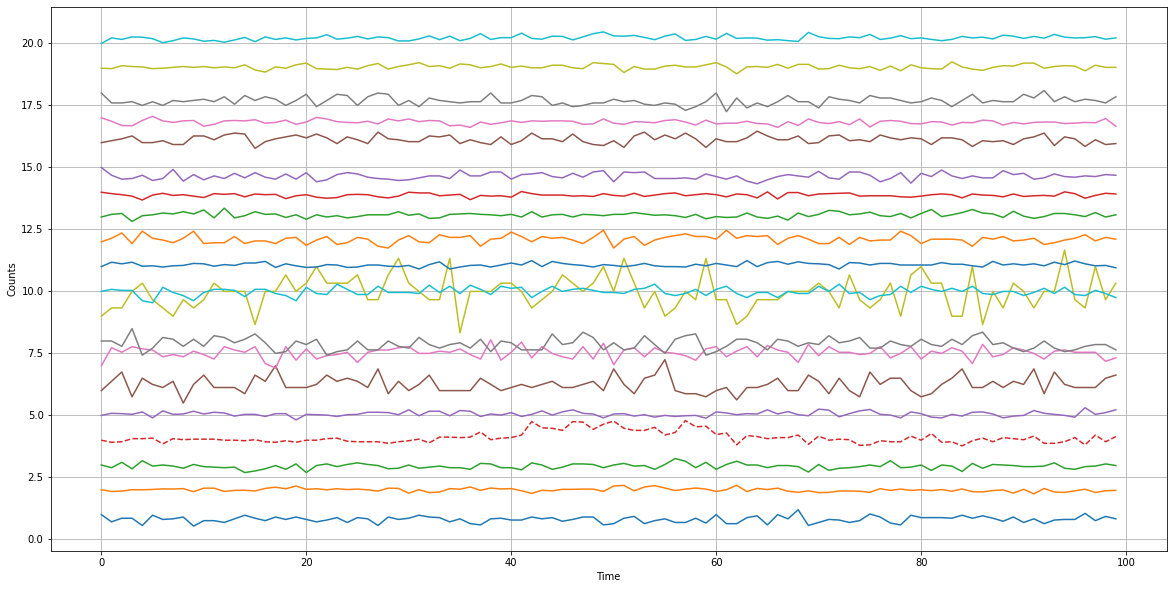

In [21]:
randid = np.random.randint(2000)
sample = dataset[randid]
print(randid)
visualize_change(sample, clustering, df)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1)

In [110]:
X_val.shape

(6540, 100)

In [23]:
class FreqDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        
        
        X = torch.tensor(X, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)

        return X, y


In [24]:
train_set = FreqDataset(X_train, y_train)
val_set = FreqDataset(X_val, y_val)
test_set = FreqDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4)

In [25]:
class RNN(nn.Module):
    
    def __init__(self, seq_len=100, input_size=1, hidden_size=256, output_size=1, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(seq_len * hidden_size * 2, hidden_size)
        # self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

        # self.hidden_cell = torch.zeros(2, 1, self.hidden_size)

    def forward(self, input_seq):
        batch_size = input_seq.shape[0]
        
        lstm_out, (hid, cel) = self.lstm(input_seq.view(batch_size ,-1, self.input_size))
#         print('lstm', lstm_out.shape)
#         print('hid', hid[0].shape)
        # out = self.fc1(hid.reshape(batch_size, -1))
        out = self.fc1(lstm_out.reshape(batch_size, -1))
        out = self.fc2(self.dropout(out))
        
        return out

In [26]:
model = RNN(dropout=0).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device))

In [27]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    # for i, batch in tqdm(enumerate(data_loader), total=len(data_loader), desc='Train'):
    for batch in data_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
#         print('inputs', inputs.shape)
#         print('output', outputs.shape)
#         print('labels', labels.shape)
        outputs = outputs.squeeze(1)
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
#         print(outputs)
#         print(labels)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(data_loader)

def evaluate(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0
    accuracy = 0
    y_pred = torch.tensor([], dtype=bool).to(device)
    y_true = torch.tensor([], dtype=bool).to(device)
    
    with torch.no_grad():
        for batch in data_loader:

            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
#             print('output', outputs.shape)
#             print('labels', labels.shape)
            outputs = outputs.squeeze(1)

            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) >= 0.5)
            y_pred = torch.cat([y_pred, preds])
            y_true = torch.cat([y_true, labels])
            
#             accuracy += (preds == labels).sum()
#             n_sample += len(labels)
    
    epoch_loss = epoch_loss / len(data_loader)
    # accuracy = accuracy.cpu().item()
    # accuracy = accuracy / n_sample
    return epoch_loss, y_true.cpu().numpy(), y_pred.cpu().numpy()
    

In [28]:
N_EPOCH = 50
for epoch in range(N_EPOCH):
    
    t0 = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, y_true, y_pred = evaluate(model, val_loader, criterion)
    
    duration = (time.time() - t0) / 60
    
    f1 = f1_score(y_true, y_pred)
    print(f'Epoch: {epoch+1} | Time: {duration:.2f} mins | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | F1: {f1:.3f}')
    # print(classification_report(y_true, y_pred))


Epoch: 1 | Time: 0.17 mins | Train Loss: 0.583 | Val Loss: 0.434 | F1: 0.810
Epoch: 2 | Time: 0.16 mins | Train Loss: 0.430 | Val Loss: 0.416 | F1: 0.840
Epoch: 3 | Time: 0.16 mins | Train Loss: 0.395 | Val Loss: 0.414 | F1: 0.864
Epoch: 4 | Time: 0.16 mins | Train Loss: 0.387 | Val Loss: 0.413 | F1: 0.867
Epoch: 5 | Time: 0.16 mins | Train Loss: 0.424 | Val Loss: 0.347 | F1: 0.858
Epoch: 6 | Time: 0.16 mins | Train Loss: 0.327 | Val Loss: 0.335 | F1: 0.862
Epoch: 7 | Time: 0.16 mins | Train Loss: 0.327 | Val Loss: 0.354 | F1: 0.861
Epoch: 8 | Time: 0.17 mins | Train Loss: 0.325 | Val Loss: 0.379 | F1: 0.839
Epoch: 9 | Time: 0.17 mins | Train Loss: 0.329 | Val Loss: 0.384 | F1: 0.871
Epoch: 10 | Time: 0.17 mins | Train Loss: 0.358 | Val Loss: 0.355 | F1: 0.855
Epoch: 11 | Time: 0.16 mins | Train Loss: 0.321 | Val Loss: 0.308 | F1: 0.889
Epoch: 12 | Time: 0.17 mins | Train Loss: 0.282 | Val Loss: 0.280 | F1: 0.905
Epoch: 13 | Time: 0.16 mins | Train Loss: 0.276 | Val Loss: 0.269 | F1: 0

In [29]:
test_loss, y_true, y_pred = evaluate(model, test_loader, criterion)

In [32]:
train_loss, y_true, y_pred = evaluate(model, train_loader, criterion)

In [33]:
test_loss, train_loss

(0.271284740883857, 0.21309925175072358)

In [37]:
confusion_matrix(y_true, y_pred)

array([[3495,  137],
       [  41,  327]])

In [30]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9884    0.9623    0.9752      3632
         1.0     0.7047    0.8886    0.7861       368

    accuracy                         0.9555      4000
   macro avg     0.8466    0.9254    0.8806      4000
weighted avg     0.9623    0.9555    0.9578      4000



In [121]:
sum(y_true == True)

368

In [120]:
len(y_true)

4000

In [99]:
sample.head()

,id,category,time,event,cluster
0,3-6265210,autot,32,periodic,1
1,3-7781405,autot,34,periodic,19
2,3-9431922,autot,89,periodic,14
3,3-5058573,autot,44,periodic,19
4,3-9155135,autot,98,periodic,3


In [39]:
def get_metrics(df, y_true, y_pred, maj_cats, target):
    accuracy = 0   # accuracy of detect correctly clusters have the target category as major
    precision = 0  # accuracy of detect how many articles in cluster are target category
    recall = 0    # accuracy of detect how many articles in target category are in choosen clusters
    
    pred_ids = np.argwhere(y_pred > 0).squeeze(1)
    n_cluster = len(pred_ids)

    df['target'] = (df['event'] != 'noise')
    target_cluster = df[df['target'] == True]
    
    for i in pred_ids:
        pred_cat = maj_cats[i]
        cluster = df[df['cluster'] == i]
        
        if pred_cat == target:
            accuracy += 1
        # calculate the prec and recall
        if len(cluster['target']) > 0:
            precision += cluster['target'].mean()
        recall += cluster['target'].sum()
    
    # if there is output 
    if n_cluster:
        accuracy = accuracy / n_cluster
        precision = precision / n_cluster
    
    recall = recall / target_cluster.shape[0]
    
    return accuracy, precision, recall


def evaluate_pipeline(samples, labels, preds, maj_cats):
    n_samples = len(samples)
    acc = np.zeros(n_samples)
    prc = np.zeros(n_samples)
    rec = np.zeros(n_samples)
    f = np.zeros(n_samples)
    n_cluster = 20
    
    for i, sample in enumerate(tqdm(samples)):
        target = get_target(sample)
        y_true = labels[i*n_cluster: (i+1)*n_cluster]
        y_pred = preds[i*n_cluster: (i+1)*n_cluster]
        cats = maj_cats[i*n_cluster: (i+1)*n_cluster]
        
        acc[i], prc[i], rec[i] = get_metrics(sample, y_true, y_pred, cats, target)
        if (prc[i] + rec[i]) != 0:
            f[i] = 2 * prc[i] * rec[i] / (prc[i] + rec[i])
        
    return acc, prc, rec, f

In [40]:
accs, precs, recs, f_micro = evaluate_pipeline(test_samples, y_true, y_pred, maj_cats)

100%|██████████| 200/200 [00:03<00:00, 61.87it/s]


In [41]:
f_macro =2 * precs.mean()*recs.mean()/(precs.mean()+recs.mean())
accs.mean(), precs.mean(), recs.mean()

(0.7876904761904762, 0.6610569832918661, 0.6387197854982503)

In [42]:
f_micro = np.nan_to_num(f_micro)
print("f_micro:", f_micro.mean(), "f_macro:", f_macro)

f_micro: 0.6277533352465829 f_macro: 0.6496964474343231


In [43]:
len(test_samples)

200